### Energy Balance Climate Model (Budyko 1969)
  
- Mar 24 2021 GR6926 Spring 2021 (McKinley & Fiore)
- Nov 13 2019 GR6926 Fall 2019 (McKinley & Fiore)
- Adapted from matlab, EESC G9910 Simple Models Seminar Fall 2016 (Mike Previdi)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#Note that Budyko equation is written for temperature in celsius
#Note also that Budyko's original paper has radiation in units of kcal/cm2 each month ; we use W/m2

class budyko():
    """ energy balance climate model (Budyko style)"""
    
    def __init__(self, Q0=1336., alpha1=0.3,alpha2=0.6,s2=-0.482,T_s=-10.):
        """ constructor
        
        PARAMETERS:
        Q0: float
            incoming solar radiation (Solar constant) units are W/m2
        alpha_s: float
            albedo at ice line, taken to be average of alpha1 and alpha2     
        alpha1: float
            albedo in non-ice covered state
        alpha2: float
            albedo in ice-covered state
        s2: float
             coefficient for second order Legendre polynomial
        T_s: float
            critical temperature below which ice advances and shifts to alpha2 albedo
        """
        self.Q0 = Q0
        self.alpha_s = 0.5*(alpha1+alpha2)
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.s2 = s2
        self.T_s = T_s
        
        return None   

    def get_roots(self):
        # Find roots: r1 is the coefficient for x^3; r2 for x^2; r1 for x, and r4 incorporates all constants
        r1 = -self.Q0*self.C*(self.alpha1-self.alpha2)*self.s2*(1/(8*self.B))
        r2 = ((3*self.Q0*self.s2)/8)*(1-self.alpha_s)
        r3 = ((self.Q0*self.C*(self.alpha1-self.alpha2))/(8*self.B))*(self.s2-2)
        r4 = (self.Q0/4)-((self.Q0*self.s2)/8)-((self.Q0*self.alpha_s)/4)+((self.Q0*self.alpha_s*self.s2)/8)+((self.Q0*self.C)/(4*self.B))-((self.Q0*self.C*self.alpha2)/(4*self.B))-self.k
        self.iceline = np.roots(np.poly1d([r1,r2,r3,r4]))
        print(self.iceline)
        #math.asin() returns in radians
        soln1=math.asin(self.iceline[1])
        soln2=math.asin(self.iceline[2])
        print('Soln 1 =',math.degrees(soln1))
        print('Soln 2 =',math.degrees(soln2))
        self.icedeg = [math.degrees(soln1),math.degrees(soln2)]
        return(self.iceline,self.icedeg)

    def get_qofx(self, A=211.1, B=1.55, C=3.74):
        """ calculate the constant needed to solve for xs (sin ice line latitude) as a function of Q
          PARAMETERS:
        
         A: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2
          B: float
            Value taken from Lindzen & Farrell (1977); see Baker & Roe 2010  W/m2/C
            A+BT is the linear relationship between OLR and T; B reflects climate sensitivity
          C: float
            Value also taken from Lindzen & Farrell (1977). This term governs meridional redistribution of heat
            Units are W/m2/C; C(T(x)-Tavg); redistribution depends on difference of local T to global mean       
        """

        self.A = A
        self.B = B
        self.C = C
        
        #constant (see Roe & Baker 2010 Equation )
        self.k=self.A+(self.B*self.T_s)+(self.C*self.T_s)+((self.C*self.A)/self.B)

        #Solve EBCM for Q as a function of x (sin(ice-line lattiude)
        #define array for x     
        x=np.linspace(0.,1.,num=1000)
        self.x = x
        self.Q=self.k/(((-self.C*(self.alpha1-self.alpha2)*self.s2*x**3)/(8*self.B))+(((3*self.s2/8)*(1-self.alpha_s)*x**2)+(((self.C*(self.alpha1-self.alpha2))/(8*self.B))*(self.s2-2)*x)+(1/4)-(self.s2/8)-(self.alpha_s/4)+(self.alpha_s*self.s2)/8)+(self.C/(4*self.B))-((self.C*self.alpha2)/(4*self.B)))
        self.Qrat=self.Q/self.Q0
        self.plot_timeserie()
        self.plot_timeserie(plot_lat = True)
        return(self.x, self.Q, self.Qrat, self.Q0)

 #Find the global stability point (ice line latitude)
    def find_gsp(self):
        # identify where Q(x) is minimum, where x = sin ice latitude
        posminQ = self.Q.argmin()
        print('index of minimum Q =', posminQ)
        print('minQ =',np.round(Q[posminQ],decimals=1),', Q0=', Q0,', minQ/Q0=',np.round(Q[posminQ]/Q0,decimals=3))
        self.gsp=self.x[posminQ]
        self.gsp_deg=math.degrees(math.asin(self.gsp))
        print('sin lat of GSP=', self.gsp)
        print('lat of GSP=',self.gsp_deg)
        return(self.gsp,self.gsp_deg)

#make a plot
    def plot_timeserie(self, plot_lat = False):
        """ plotting function """
        plt.figure(figsize=[10,8])
        if plot_lat:
            y = np.rad2deg(np.arcsin(self.x)) 
            ylim = [0,90]
            ylab = 'ice-line latitude'
        else:
            y = self.x
            ylim = [0, 1]
            ylab = 'sine of ice-line latitude'
        plt.plot(self.Qrat, y, color='black')
        plt.xlim([0.9,1.3])
        plt.ylim(ylim)
        plt.xlabel('Q/Q0',fontsize=16)
        plt.ylabel(ylab, fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Budyko EBCM Solution', fontsize=16)  
        plt.grid(which = 'major')
        return None 

#Fill in here for calculation of global temperature for iceline at any x "input_x"  and Qratio "input_Qrat"  
    def get_globalT(self,input_x,input_Qrat):
        # solve for global T based on solution for x
        ## STUDENTS TO FILL THIS IN
        #alpha_p = 
        #globalT = 
        ## STUDENTS TO FILL THIS IN
        return(globalT)
    
    def plot_T(self):
        self.globalT = ebcm.get_globalT(input_x=self.x,input_Qrat=self.Qrat)
        for x, xlab, y, ylab in zip([self.globalT, self.Qrat], 
                                    ['global mean T (C)', 'Q/Q0'], 
                                    [self.x, self.globalT], 
                                    ['sine of ice-line latitude', 'global mean T (C)']):
            """ plotting T vs sin lat """
            plt.figure(figsize=[10,8])
            plt.plot(x, u, color='black')
            plt.xlabel(xlab,fontsize=16)
            plt.ylabel(ylab, fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.title('Budyko EBCM Solution, Global Temperature, with variation in Qratio', fontsize=16) 
            plt.grid(which = 'major')      


In [4]:
ebcm=budyko()

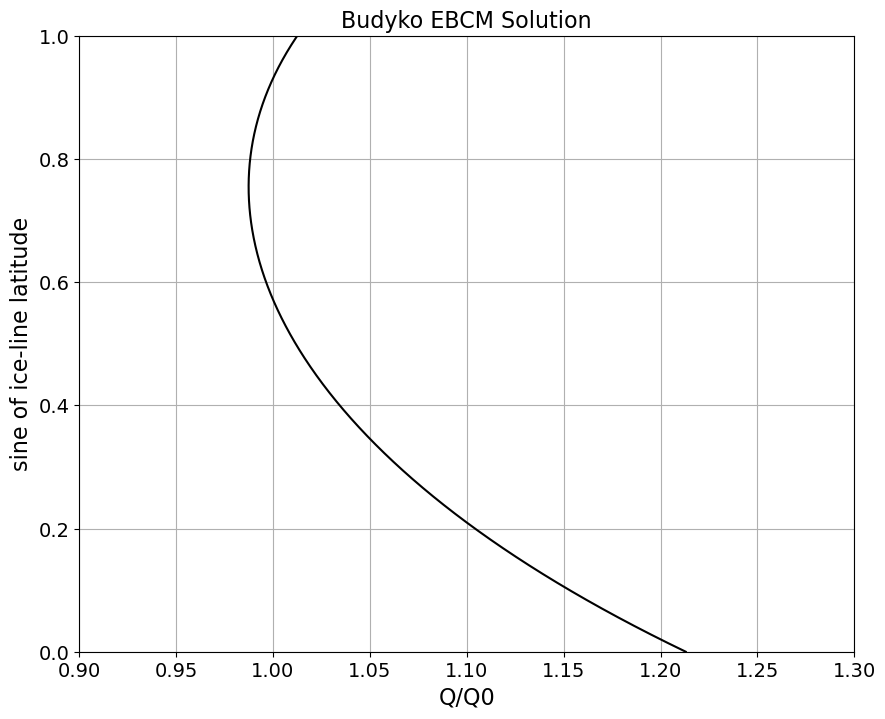

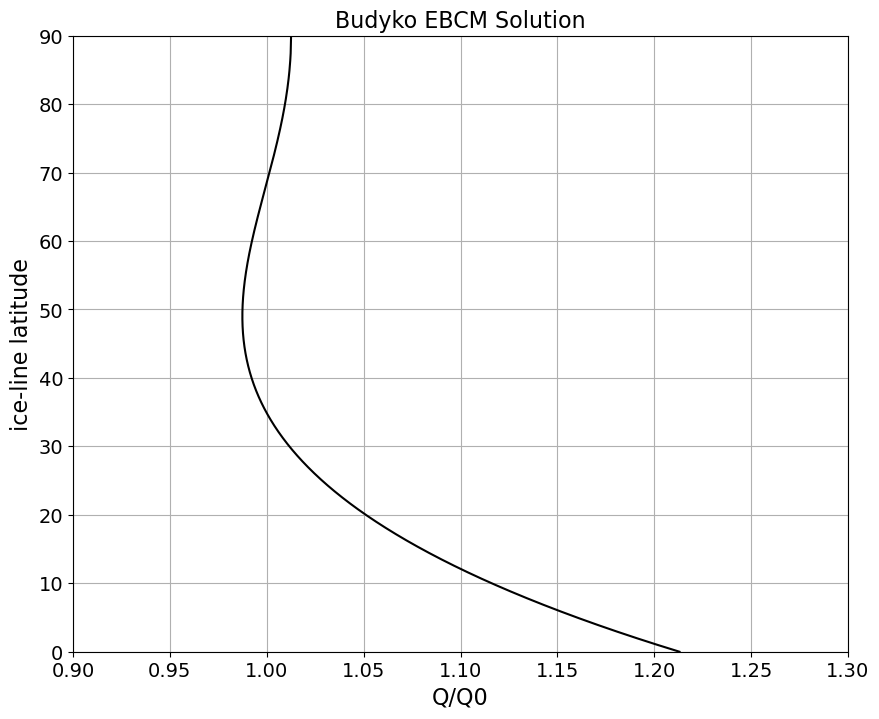

In [5]:
x,Q,Qrat,Q0=ebcm.get_qofx()

In [6]:
iceline,j = ebcm.get_roots()

[-3.78173416  0.93070733  0.57161507]
Soln 1 = 68.54534407959045
Soln 2 = 34.862926406580726


In [7]:
#Find GSP
x_gsp,x_gsp_deg=ebcm.find_gsp()

index of minimum Q = 754
minQ = 1319.2 , Q0= 1336.0 , minQ/Q0= 0.987
sin lat of GSP= 0.7547547547547547
lat of GSP= 49.00394539581304


In [8]:
# First time through; set up matrix to save result
SaveRun = Q.copy()

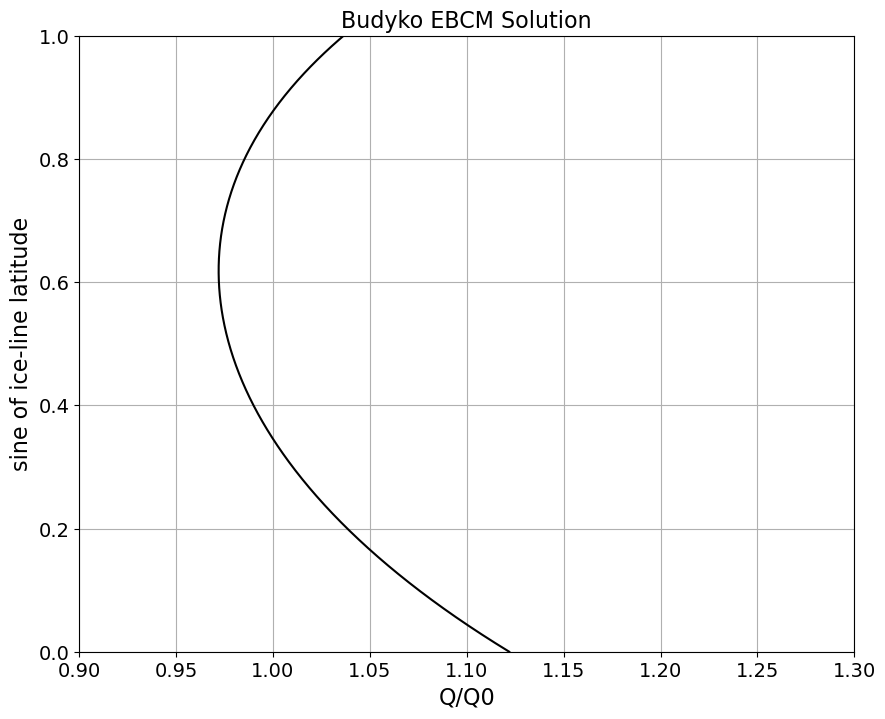

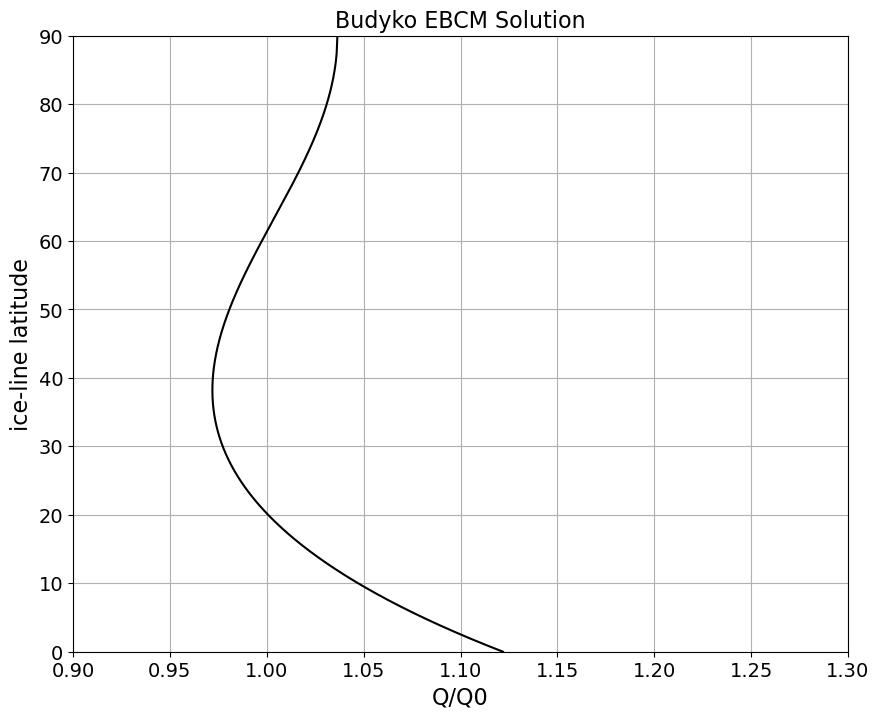

In [9]:
# Run with a different parameter choice
x,Q,Qrat,Q0=ebcm.get_qofx(B=2.2)
# Save result
SaveRun = np.vstack([SaveRun,Q])

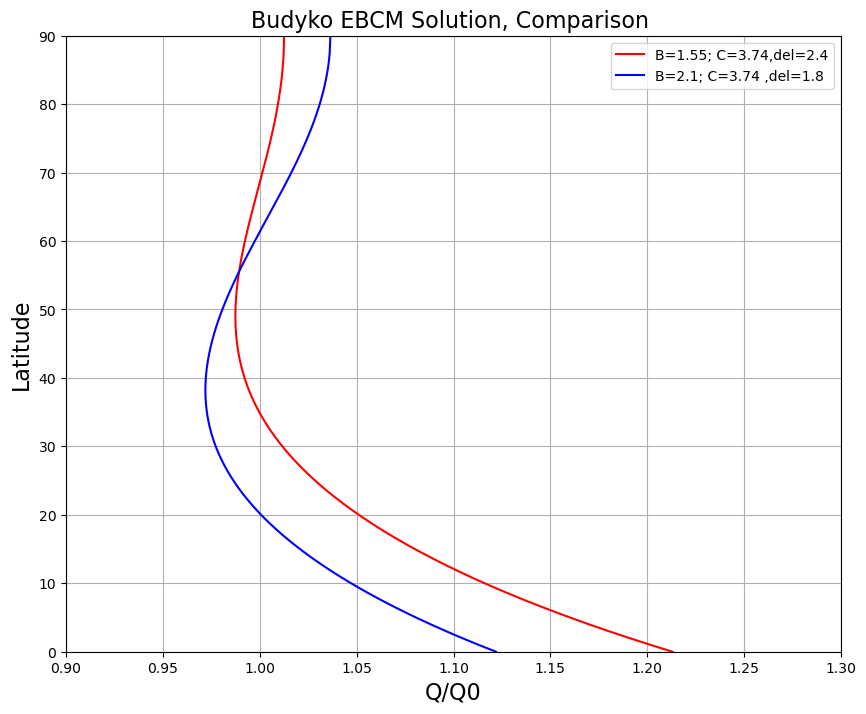

In [10]:
"Compare runs, Plotting against Latitude"
plt.figure(figsize=[10,8])
lab1, = plt.plot(SaveRun[0,:]/Q0,np.rad2deg(np.arcsin(x)),'red', label = 'B=1.55; C=3.74,del=2.4')
lab2, = plt.plot(SaveRun[1,:]/Q0,np.rad2deg(np.arcsin(x)),'blue',label = 'B=2.1; C=3.74 ,del=1.8')
" Add more comparisons here "
#lab3, = plt.plot(SaveRun[2,:]/Q0,np.rad2deg(np.arcsin(x)),'green',label = 'B=2.2; C=3.74,del=1.7')
#lab4, = plt.plot(SaveRun[3,:]/Q0,np.rad2deg(np.arcsin(x)),'black',label = 'B=2.2; C=3,del=1.4')
plt.xlim([0.9,1.3])
plt.ylim([0,90])
plt.xlabel('Q/Q0',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.legend(handles=[lab1, lab2])
#plt.legend(handles=[lab1, lab2, lab3, lab4])
plt.title('Budyko EBCM Solution, Comparison ', fontsize=16) 
plt.grid(which = 'major')

In [11]:
# Rerun default, for consideration of Global Mean T
#x,Q,Qrat,Q0=ebcm.get_qofx()
#iceline,j =ebcm.get_roots()
#x_gsp,x_gsp_deg=ebcm.find_gsp()

In [12]:
# Need to fill in Qrat here
#T_gsp = ebcm.get_globalT(input_x = x_gsp, input_Qrat = )
#print(T_gsp)
#Ticeline = ebcm.get_globalT(input_x = iceline[1],input_Qrat = )
#print(Ticeline)

In [13]:
#ebcm.plot_T()